In [1]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('Train.csv')
sample_sub = pd.read_csv('SampleSubmission.csv')
df.shape, sample_sub.shape

((1109, 2), (1017, 194))

# DEFINING/BUILDING NECCESSARY FUNCTION TO BE USED

### 1. Data Augmentation method

In [3]:
def speedNpitch(data):
    
    # Speed and Pitch Tuning.

    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

### 2. Extracting the MFCC feature as an image (Matrix format)

In [4]:

def prepare_data(df, n, aug, mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.fn):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        # Augmentation? 
        if aug == 1:
            data = speedNpitch(data)
        
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X



### 3. Confusion matrix plot 

In [5]:
        
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """ Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure  """

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### 4. Create the 2D CNN model 

In [6]:
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 193
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model





# 5. Other functions 

In [7]:


class get_results:
    '''
    We're going to create a class (blueprint template) for generating the results based on the various model approaches. 
    So instead of repeating the functions each time, we assign the results into on object with its associated variables 
    depending on each combination:
        1) MFCC with no augmentation  
        2) MFCC with augmentation 
        3) Logmelspec with no augmentation 
        4) Logmelspec with augmentation
    '''
    
    def __init__(self, model_history, model ,X_test, y_test, labels):
        self.model_history = model_history
        self.model = model
        self.X_test = X_test
        self.y_test = y_test             
        self.labels = labels

    def create_plot(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def create_results(self, model):
        '''predict on test set and get accuracy results'''
        opt = optimizers.Adam(0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        score = model.evaluate(X_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

##  MFCC without augmentation
So, what I'm about to do is use the entire MFCC data and treat it as an image, and push it through to a 2D CNN instead of a 1D CNN that we saw in previous parts. This will be without data augmentation for now. The convergence is very quick so instead of letting it run over 50 or more epochs, I'm going to just cut it at 20.

In [11]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data(df, n = n_mfcc, aug = 0, mfcc = 1)

100%|██████████| 1109/1109 [03:38<00:00,  6.82it/s]


In [17]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc
                                                    , df.label
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                    , stratify = df.label
                                                   )


# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)


Epoch 1/20
52/52 - 20s - loss: 5.4034 - acc: 0.0036 - val_loss: 5.2414 - val_acc: 0.0072
Epoch 2/20
52/52 - 20s - loss: 5.2199 - acc: 0.0181 - val_loss: 5.2016 - val_acc: 0.0144
Epoch 3/20
52/52 - 21s - loss: 5.0759 - acc: 0.0181 - val_loss: 5.2187 - val_acc: 0.0036
Epoch 4/20
52/52 - 22s - loss: 4.9983 - acc: 0.0217 - val_loss: 5.2407 - val_acc: 0.0144
Epoch 5/20
52/52 - 28s - loss: 4.9017 - acc: 0.0313 - val_loss: 5.0996 - val_acc: 0.0108
Epoch 6/20
52/52 - 33s - loss: 4.8022 - acc: 0.0481 - val_loss: 5.1959 - val_acc: 0.0072
Epoch 7/20
52/52 - 25s - loss: 4.7058 - acc: 0.0337 - val_loss: 5.0387 - val_acc: 0.0216
Epoch 8/20
52/52 - 25s - loss: 4.6332 - acc: 0.0457 - val_loss: 4.9600 - val_acc: 0.0180
Epoch 9/20
52/52 - 23s - loss: 4.5576 - acc: 0.0614 - val_loss: 4.9241 - val_acc: 0.0216
Epoch 10/20
52/52 - 27s - loss: 4.4237 - acc: 0.0818 - val_loss: 4.9177 - val_acc: 0.0288
Epoch 11/20
52/52 - 24s - loss: 4.3586 - acc: 0.0674 - val_loss: 4.9147 - val_acc: 0.0180
Epoch 12/20
52/52 -

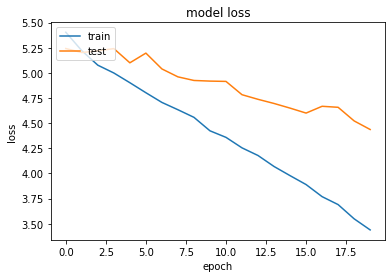

accuracy: 6.83%


In [21]:
results = get_results(model_history,model,X_test,y_test, df.label.unique())
results.create_plot(model_history)
results.create_results(model)

For 20 epochs we had the following:
 loss: 3.4386 - acc: 0.2250 - val_loss: 4.4367 - val_acc: 0.0683

Had an accuracy of 6.83% on the test set but didnt converge even though it looked like training it on more epochs would improve both the train and test loss/accuracy because the curves in the plot above has not yet shown a sign of a plateu yet which mean there might be room for possible improvement if we increase the number of epochs.

## 3. MFCC with Augmentation

In [22]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc_aug = prepare_data(df, n = n_mfcc, aug = 1, mfcc = 1)

100%|██████████| 1109/1109 [02:29<00:00,  7.54it/s]


In [24]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc_aug
                                                    , df.label
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                    , stratify = df.label
                                                   )

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
# mean = np.mean(X_train, axis=0)
# std = np.std(X_train, axis=0)

# X_train = (X_train - mean)/std
# X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)


Epoch 1/20
52/52 - 20s - loss: 5.4487 - acc: 0.0024 - val_loss: 11.9914 - val_acc: 0.0072
Epoch 2/20
52/52 - 20s - loss: 5.3303 - acc: 0.0072 - val_loss: 6.1392 - val_acc: 0.0072
Epoch 3/20
52/52 - 19s - loss: 5.2500 - acc: 0.0072 - val_loss: 5.6177 - val_acc: 0.0036
Epoch 4/20
52/52 - 19s - loss: 5.1845 - acc: 0.0036 - val_loss: 5.1418 - val_acc: 0.0216
Epoch 5/20
52/52 - 20s - loss: 5.1153 - acc: 0.0144 - val_loss: 5.1710 - val_acc: 0.0036
Epoch 6/20
52/52 - 20s - loss: 5.0569 - acc: 0.0144 - val_loss: 5.0728 - val_acc: 0.0144
Epoch 7/20
52/52 - 20s - loss: 4.9841 - acc: 0.0181 - val_loss: 5.0314 - val_acc: 0.0144
Epoch 8/20
52/52 - 20s - loss: 4.9452 - acc: 0.0132 - val_loss: 5.1486 - val_acc: 0.0108
Epoch 9/20
52/52 - 21s - loss: 4.9253 - acc: 0.0193 - val_loss: 4.9507 - val_acc: 0.0324
Epoch 10/20
52/52 - 20s - loss: 4.8691 - acc: 0.0253 - val_loss: 4.9495 - val_acc: 0.0252
Epoch 11/20
52/52 - 23s - loss: 4.8241 - acc: 0.0229 - val_loss: 4.9281 - val_acc: 0.0288
Epoch 12/20
52/52 

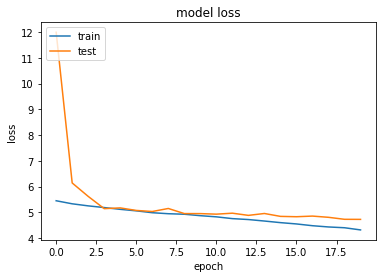

accuracy: 3.24%


In [25]:
results = get_results(model_history,model,X_test,y_test, df.label.unique())
results.create_plot(model_history)
results.create_results(model)

After 20 epochs, we had the following:
loss: 4.3163 - acc: 0.0698 - val_loss: 4.7255 - val_acc: 0.0324

This is really worst than the MFCC without augmentation .Lower train accuracy, higher train loss and even higher test loss. This may not be reliable.

Here the curves seems to have converged but we had a lower test accuracy of 3.24% . Notice that the test loss and train loss began to diverge after the 8th epoch. we can train around 8 epochs and see how the leaderboard responds.

## 4. Log-melspectogram without augmentation
The accuracy is 60%, a slight drop from 64% without augmentation which is interesting and slightly unexpected. The plot of the logloss also indicates that it's converged. Suppose augmentation doesn't really do much for MFCC here... Note that due to some weird behaviour with the standardisation, I had to turn it off. So maybe that has some minor impact on the accuracy drop.

Now, we're going to look at another type of feature call log-melspectogram. I've not covered it in this series but you can check out another kernel where I covered this feature quite extensively, right here. But in short, if we treat the log-melspectogram like an image just like we did with the MFCC, then we can feed it into the same 2D CNN architecture that we built! Lets give it a try, without augmentation first...

In [26]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
specgram = prepare_data(df, n = n_melspec, aug = 0, mfcc = 0)

100%|██████████| 1109/1109 [01:44<00:00, 11.27it/s]


In [27]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(specgram
                                                    , df.label
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                    , stratify = df.label
                                                   )



# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)

Epoch 1/20
52/52 - 42s - loss: 5.3754 - acc: 0.0048 - val_loss: 5.8010 - val_acc: 0.0108
Epoch 2/20
52/52 - 40s - loss: 5.2543 - acc: 0.0120 - val_loss: 5.2044 - val_acc: 0.0108
Epoch 3/20
52/52 - 46s - loss: 5.1656 - acc: 0.0144 - val_loss: 5.2014 - val_acc: 0.0144
Epoch 4/20
52/52 - 43s - loss: 5.0774 - acc: 0.0120 - val_loss: 5.2043 - val_acc: 0.0180
Epoch 5/20
52/52 - 44s - loss: 5.0154 - acc: 0.0168 - val_loss: 5.1004 - val_acc: 0.0180
Epoch 6/20
52/52 - 46s - loss: 4.9502 - acc: 0.0205 - val_loss: 5.0460 - val_acc: 0.0216
Epoch 7/20
52/52 - 45s - loss: 4.8715 - acc: 0.0373 - val_loss: 5.0578 - val_acc: 0.0252
Epoch 8/20
52/52 - 46s - loss: 4.7791 - acc: 0.0385 - val_loss: 5.0636 - val_acc: 0.0108
Epoch 9/20
52/52 - 45s - loss: 4.7253 - acc: 0.0481 - val_loss: 4.9176 - val_acc: 0.0360
Epoch 10/20
52/52 - 47s - loss: 4.6077 - acc: 0.0578 - val_loss: 4.8617 - val_acc: 0.0468
Epoch 11/20
52/52 - 48s - loss: 4.4819 - acc: 0.0590 - val_loss: 4.8154 - val_acc: 0.0612
Epoch 12/20
52/52 -

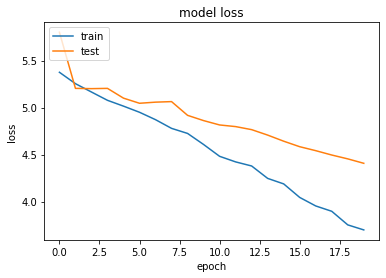

accuracy: 8.63%


In [28]:
results = get_results(model_history,model,X_test,y_test, df.label.unique())
results.create_plot(model_history)
results.create_results(model)

After 20 epochs
loss: 3.6996 - acc: 0.1769 - val_loss: 4.4077 - val_acc: 0.0863

Much better test accuracy than the mfcc without aug with an accuracy  of 8.63(previously 6.83 as highest).Although, the train accuracy for for mfcc without aug was higher. Training this on a continous increasing epochs may be dangerous has the train and test loss are already began its divergence after the 3rd epoch. It also prooves to continue in that same manner.

## 5. Log-melspectogram with augmentation¶
63% accuracy for a log-melspectogram. Slighlty lower than MFCC but very close. Notice however from the logloss plot, the log-melspectogram accuracy potential hasn't quite plateau yet. It's likely that higher number of epochs the accuracy could surpass that of the MFCC, albeit slightly. Eitherways, very interesting!

So now let's see what happens if we apply the same data augmentation here.

In [29]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
aug_specgram = prepare_data(df,  n = n_melspec, aug = 1, mfcc = 0)

100%|██████████| 1109/1109 [02:21<00:00,  9.24it/s]


In [30]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(aug_specgram
                                                    , df.label
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                    , stratify = df.label
                                                   )



# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)

Epoch 1/20
52/52 - 44s - loss: 5.4193 - acc: 0.0108 - val_loss: 5.3209 - val_acc: 0.0000e+00
Epoch 2/20
52/52 - 48s - loss: 5.2213 - acc: 0.0120 - val_loss: 5.1629 - val_acc: 0.0180
Epoch 3/20
52/52 - 50s - loss: 5.1249 - acc: 0.0168 - val_loss: 5.1943 - val_acc: 0.0036
Epoch 4/20
52/52 - 49s - loss: 5.0459 - acc: 0.0156 - val_loss: 5.1184 - val_acc: 0.0144
Epoch 5/20
52/52 - 49s - loss: 4.9583 - acc: 0.0168 - val_loss: 5.0039 - val_acc: 0.0252
Epoch 6/20
52/52 - 50s - loss: 4.8816 - acc: 0.0241 - val_loss: 5.0000 - val_acc: 0.0396
Epoch 7/20
52/52 - 50s - loss: 4.7646 - acc: 0.0289 - val_loss: 5.0007 - val_acc: 0.0468
Epoch 8/20
52/52 - 56s - loss: 4.6619 - acc: 0.0361 - val_loss: 4.9878 - val_acc: 0.0324
Epoch 9/20
52/52 - 54s - loss: 4.6247 - acc: 0.0590 - val_loss: 4.8937 - val_acc: 0.0360
Epoch 10/20
52/52 - 49s - loss: 4.5457 - acc: 0.0590 - val_loss: 4.7756 - val_acc: 0.0396
Epoch 11/20
52/52 - 60s - loss: 4.4611 - acc: 0.0734 - val_loss: 4.7317 - val_acc: 0.0432
Epoch 12/20
52/

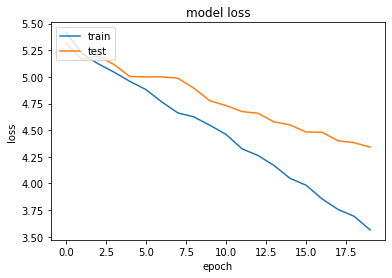

accuracy: 9.71%


In [31]:
results = get_results(model_history,model,X_test,y_test, df.label.unique())
results.create_plot(model_history)
results.create_results(model)

loss: 3.5642 - acc: 0.2250 - val_loss: 4.3409 - val_acc: 0.0971

best performance so far....log-mel with aug has prooven to have a higher test accuracy, lower, train and test loss as well. Although divergence has already started after 3rd epoch but then we can still further increase the epoch and check for possible improvements.As well as apply other augmentation techniques

## Pre- Processing Test set

In [12]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
test_set = prepare_data(sample_sub,  n = n_melspec, aug = 1, mfcc = 0)

100%|██████████| 1017/1017 [01:57<00:00,  8.77it/s]


In [14]:
# Normalization as per the standard NN process
mean = np.mean(test_set, axis=0)
std = np.std(test_set, axis=0)

test_set = (test_set - mean)/std



## INCREASING EPOCHS FOR EACH OF THE FOUR TRIALS ABOVE AND TESTING ON THE TEST SET TO SEE PERF OF LB

In [8]:
# pre-processing train_set for mel-log with aug # I seperated it from the previous
# above so as not to clear/distort/confuse the result already obtained.
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
aug_specgram = prepare_data(df,  n = n_melspec, aug = 1, mfcc = 0)

100%|██████████| 1109/1109 [02:08<00:00,  8.40it/s]


In [23]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(aug_specgram
                                                    , df.label
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                    , stratify = df.label
                                                   )



# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=10)

Epoch 1/10
52/52 - 32s - loss: 5.3918 - acc: 0.0048 - val_loss: 5.6019 - val_acc: 0.0108
Epoch 2/10
52/52 - 31s - loss: 5.2111 - acc: 0.0108 - val_loss: 5.2355 - val_acc: 0.0072
Epoch 3/10
52/52 - 35s - loss: 5.1367 - acc: 0.0193 - val_loss: 5.1847 - val_acc: 0.0144
Epoch 4/10
52/52 - 36s - loss: 5.0251 - acc: 0.0205 - val_loss: 5.0909 - val_acc: 0.0180
Epoch 5/10
52/52 - 36s - loss: 4.9535 - acc: 0.0144 - val_loss: 5.1008 - val_acc: 0.0144
Epoch 6/10
52/52 - 38s - loss: 4.9140 - acc: 0.0325 - val_loss: 5.0189 - val_acc: 0.0252
Epoch 7/10
52/52 - 40s - loss: 4.8094 - acc: 0.0349 - val_loss: 5.0244 - val_acc: 0.0216
Epoch 8/10
52/52 - 46s - loss: 4.7411 - acc: 0.0493 - val_loss: 4.9768 - val_acc: 0.0252
Epoch 9/10
52/52 - 41s - loss: 4.6722 - acc: 0.0469 - val_loss: 4.9169 - val_acc: 0.0288
Epoch 10/10
52/52 - 44s - loss: 4.5665 - acc: 0.0554 - val_loss: 4.9033 - val_acc: 0.0288


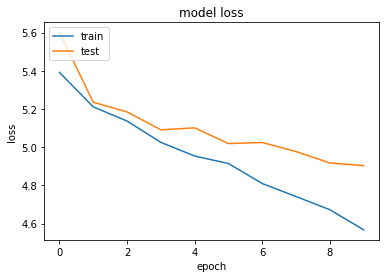

accuracy: 2.88%


In [24]:
results = get_results(model_history,model,X_test,y_test, df.label.unique())
results.create_plot(model_history)
results.create_results(model)

In [25]:
# #predicting the test set proper
ssd = model.predict(test_set)

In [26]:
#copying sample_sub into a new variable
samp = sample_sub.copy()

#obtaining column list
wwe=samp.columns

#eliminating the fn column
wwe = wwe[1:]

# creating the dataframe 
df3 = pd.DataFrame(data = ssd,  
                  index = None,  
                  columns = wwe) 

#Adding back the fn column to submission file but first assigning it to a variable
tio = sample_sub['fn']

#now we combine all datasets together
cbd =pd.concat([tio,df3], axis=1)

cbd.to_csv('Sub19.csv', index=False)

## OBSERVATION

1. After predicting the test_set using the trained model for the log-mel with      aug,we obtained a leader board score of 5.7 loss for 20 epochs...we got same    score for 10 epochs.

2. I reduced the epochs to 8 but it only improved to 5.5 